# BMS_SOC_TCM_1.0.0

Loaded MGFarm_18650_C01
Gesamtdaten: 17167046, wir nehmen 25% = 4291761 Zeilen.
Train: 1716704  |  Val: 1716704  |  Test: 858353


/tmp/ipykernel_181308/1243740231.py:228: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/florianr/anaconda3/envs/ml1/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


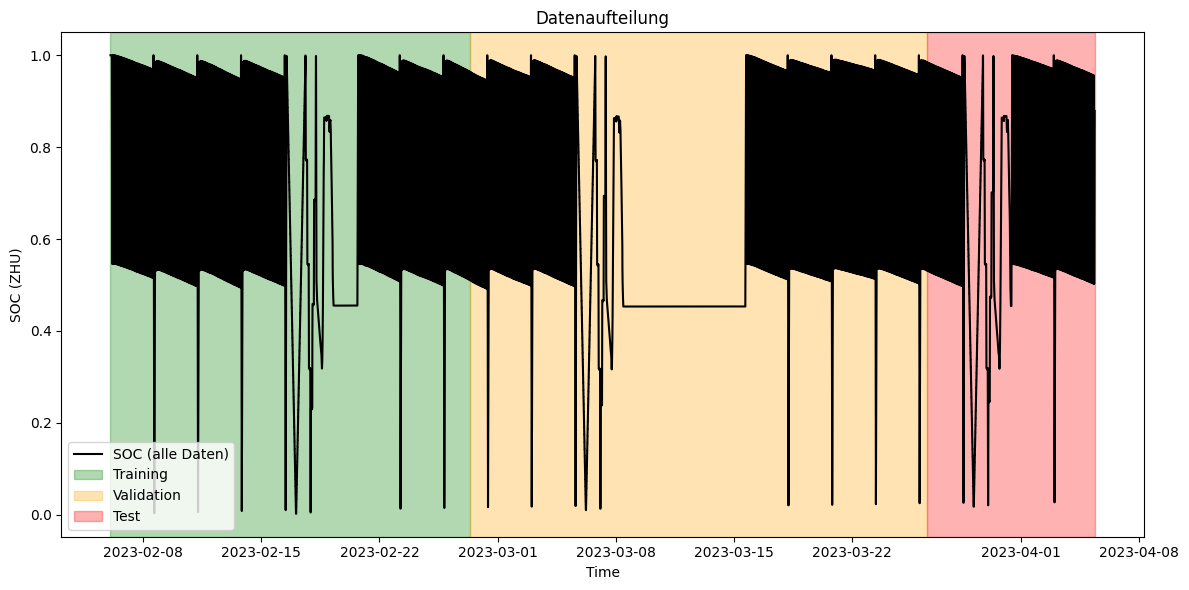

Epoch 001/30, Train MSE: 1.339046, Val MSE: 0.083312, NoImprove: 0


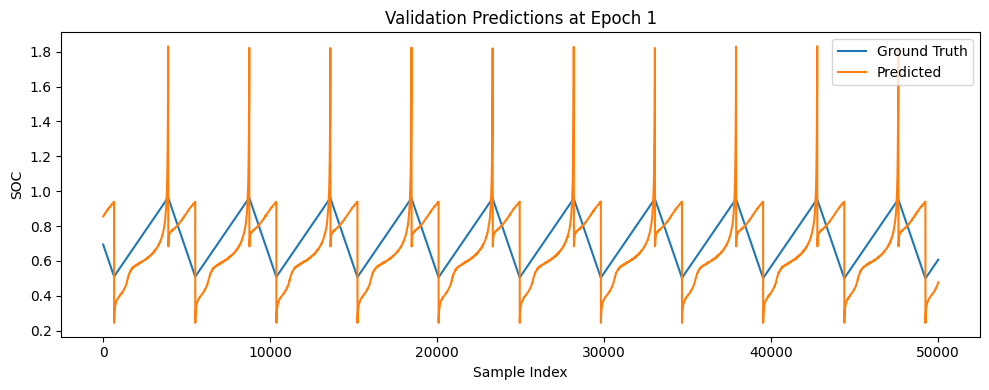

Epoch 002/30, Train MSE: 0.335766, Val MSE: 0.120170, NoImprove: 1


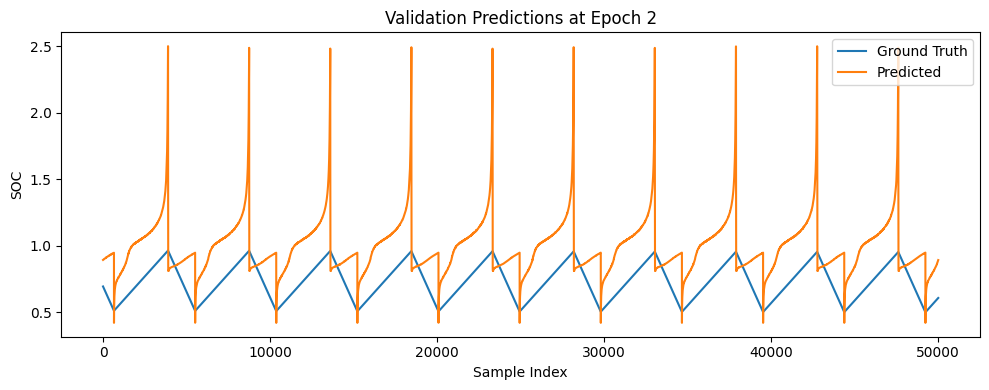

Epoch 003/30, Train MSE: 0.129410, Val MSE: 0.094611, NoImprove: 2


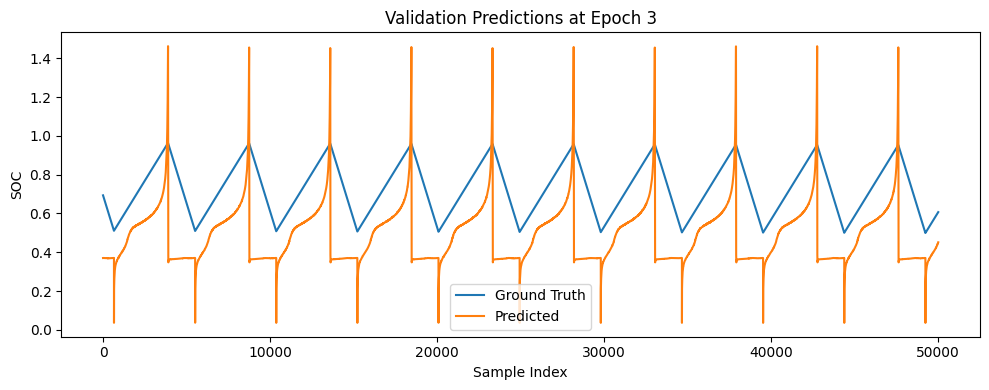

Epoch 004/30, Train MSE: 0.131465, Val MSE: 0.126426, NoImprove: 3


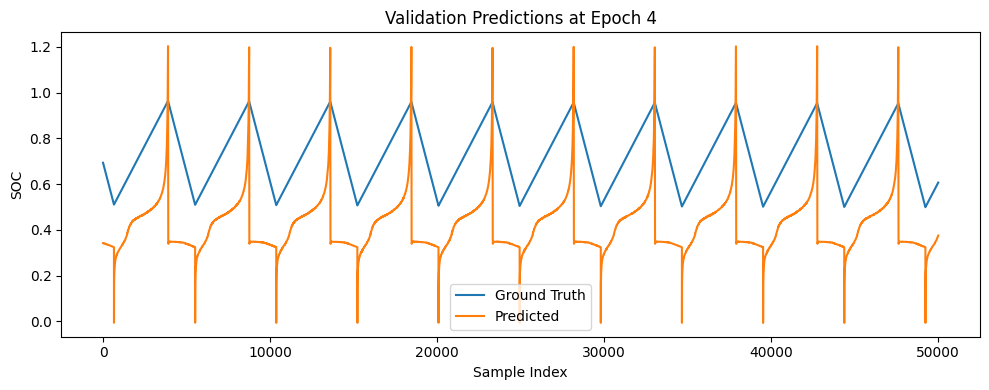

Epoch 005/30, Train MSE: 0.114015, Val MSE: 0.062164, NoImprove: 0


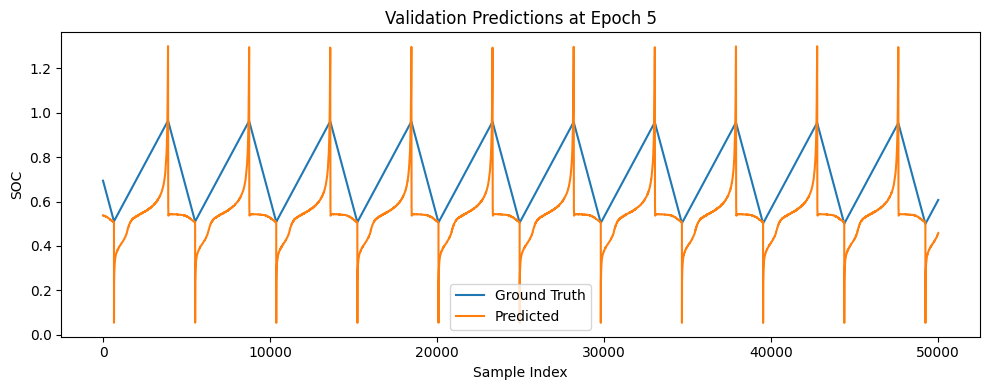

Epoch 006/30, Train MSE: 0.060233, Val MSE: 0.022622, NoImprove: 0


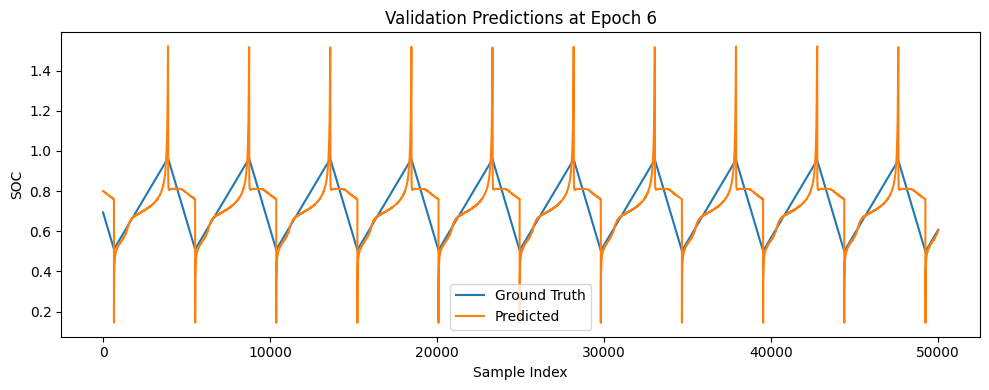

Epoch 007/30, Train MSE: 0.050755, Val MSE: 0.026566, NoImprove: 1


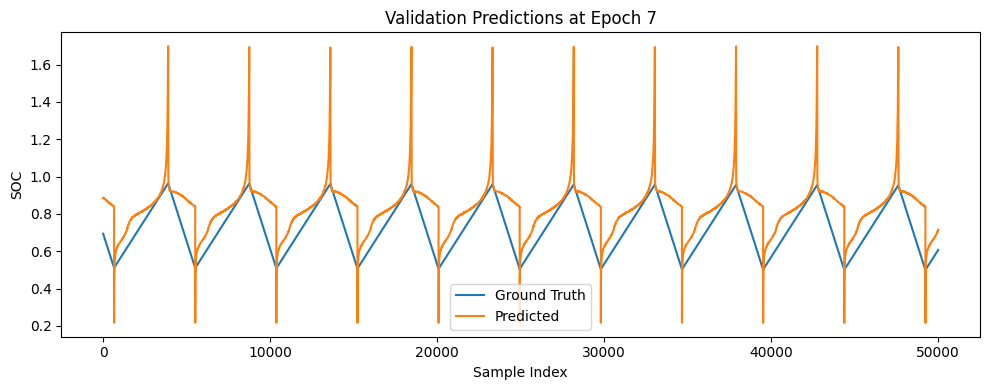

Epoch 008/30, Train MSE: 0.051791, Val MSE: 0.019198, NoImprove: 0


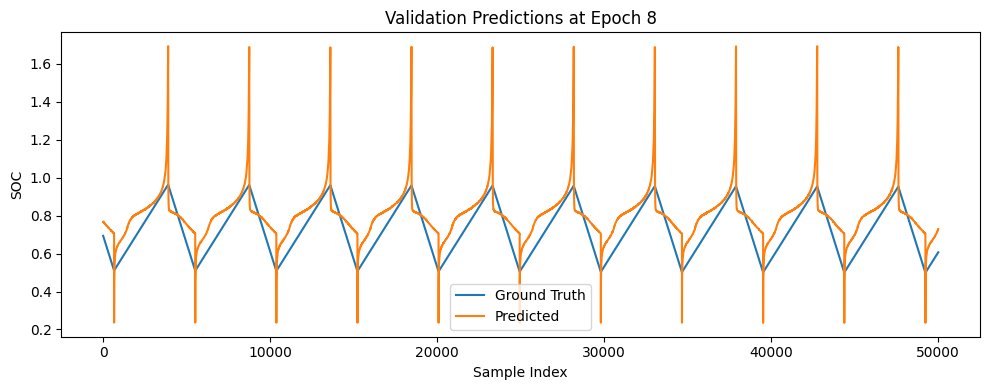

Epoch 009/30, Train MSE: 0.038621, Val MSE: 0.016098, NoImprove: 0


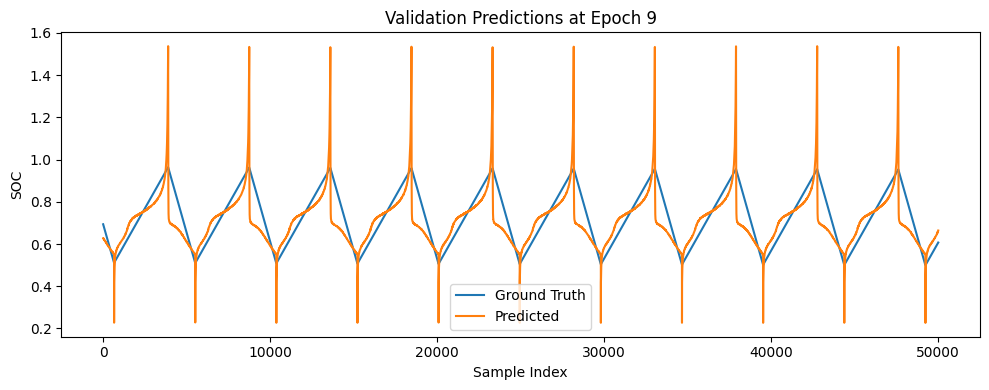

Epoch 010/30, Train MSE: 0.033833, Val MSE: 0.020675, NoImprove: 1


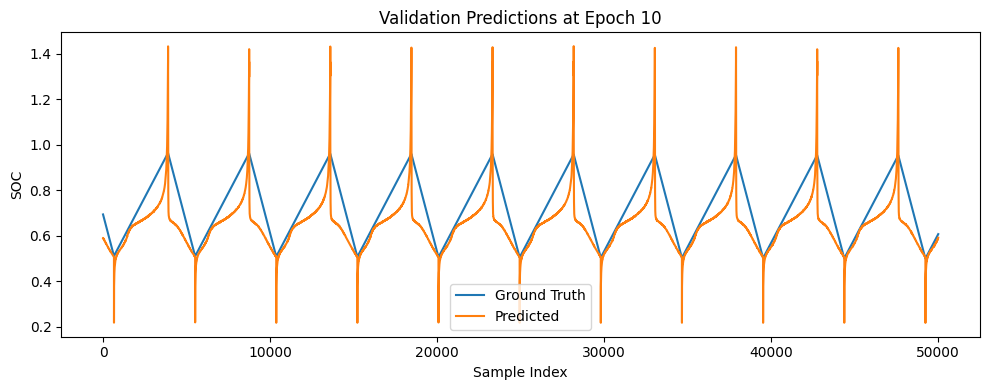

Epoch 011/30, Train MSE: 0.033237, Val MSE: 0.017899, NoImprove: 2


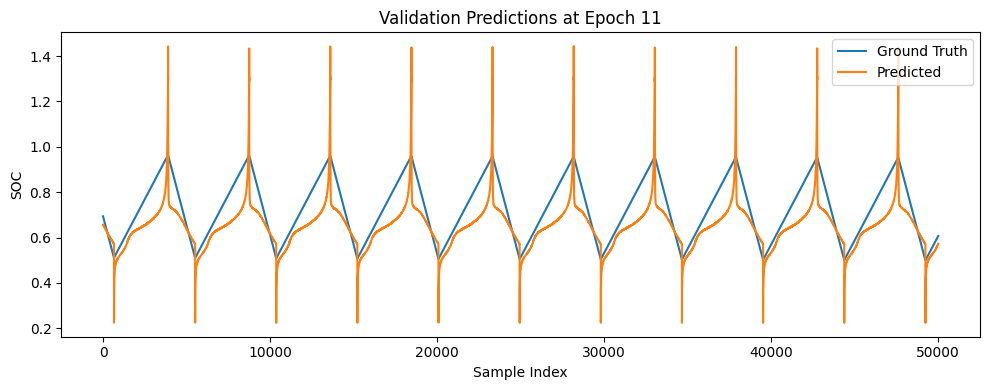

Epoch 012/30, Train MSE: 0.029031, Val MSE: 0.012731, NoImprove: 0


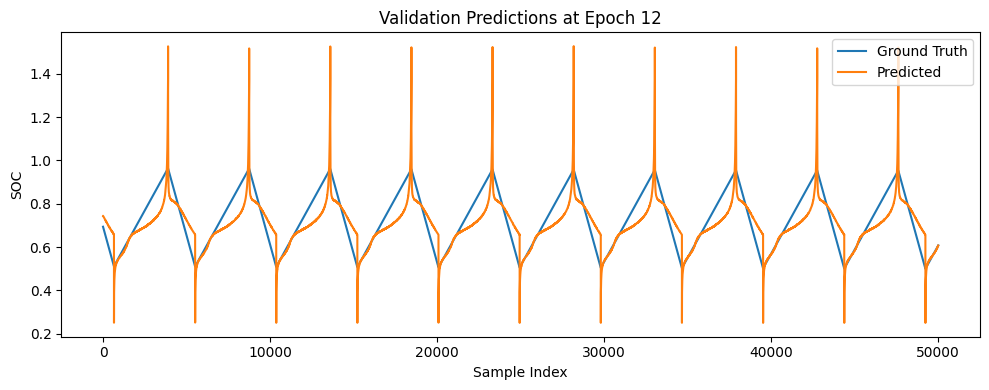

Epoch 013/30, Train MSE: 0.026698, Val MSE: 0.010866, NoImprove: 0


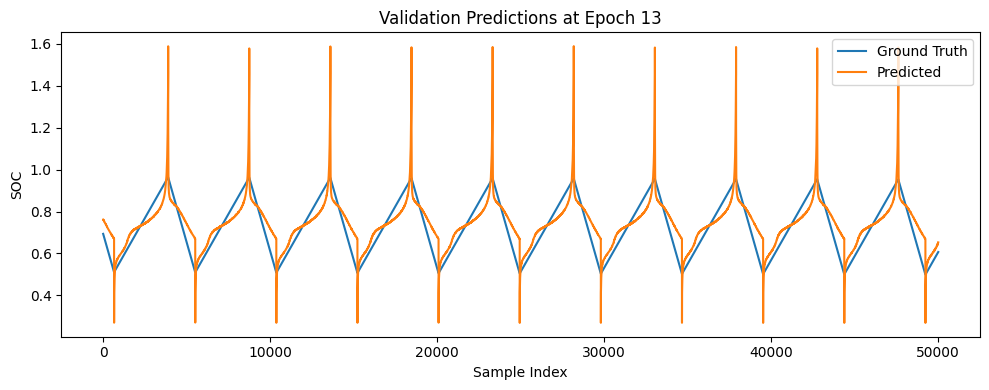

Epoch 014/30, Train MSE: 0.025491, Val MSE: 0.010152, NoImprove: 0


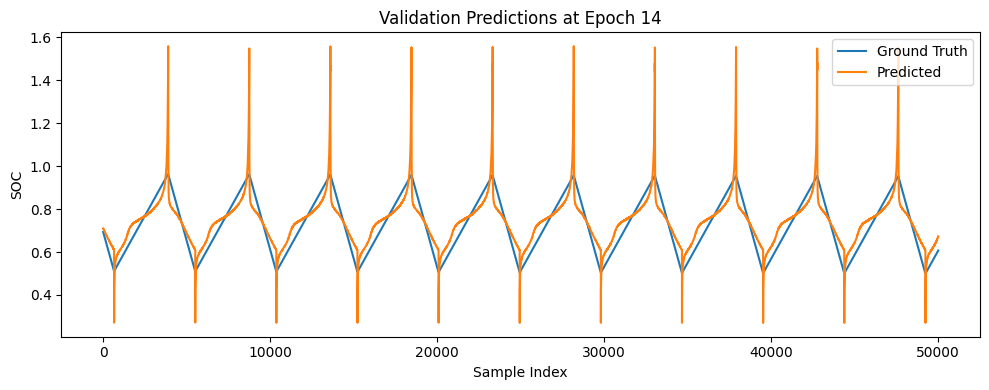

Epoch 015/30, Train MSE: 0.023646, Val MSE: 0.010694, NoImprove: 1


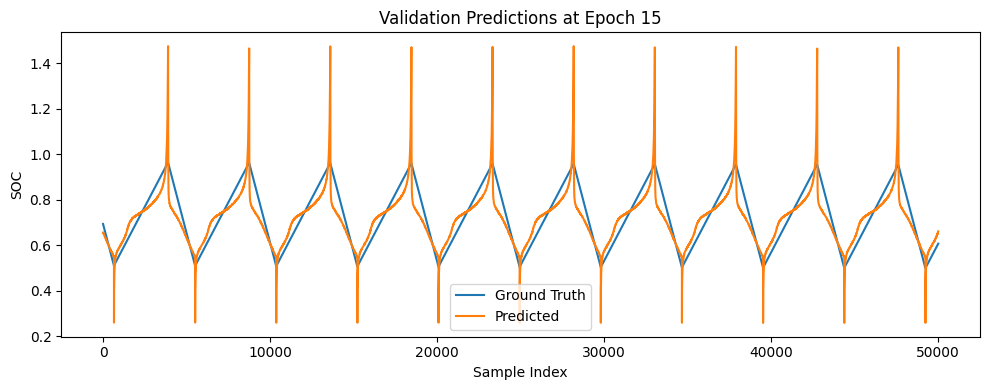

Epoch 016/30, Train MSE: 0.022321, Val MSE: 0.010772, NoImprove: 2


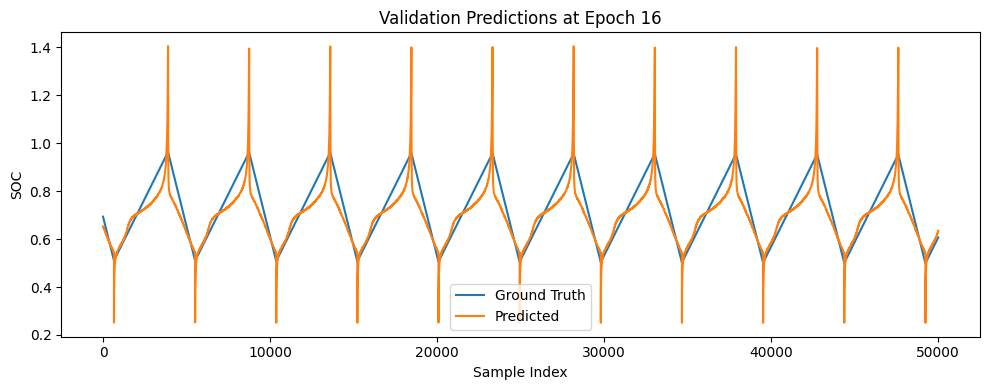

Epoch 017/30, Train MSE: 0.021030, Val MSE: 0.010159, NoImprove: 3


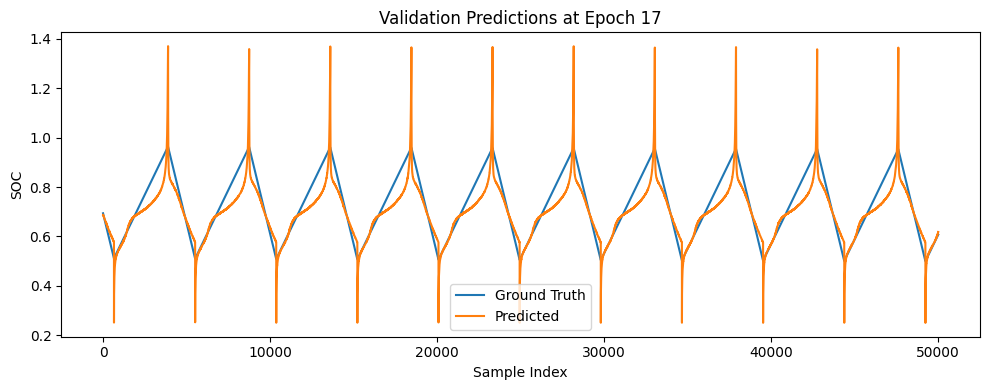

Epoch 018/30, Train MSE: 0.020240, Val MSE: 0.009570, NoImprove: 0


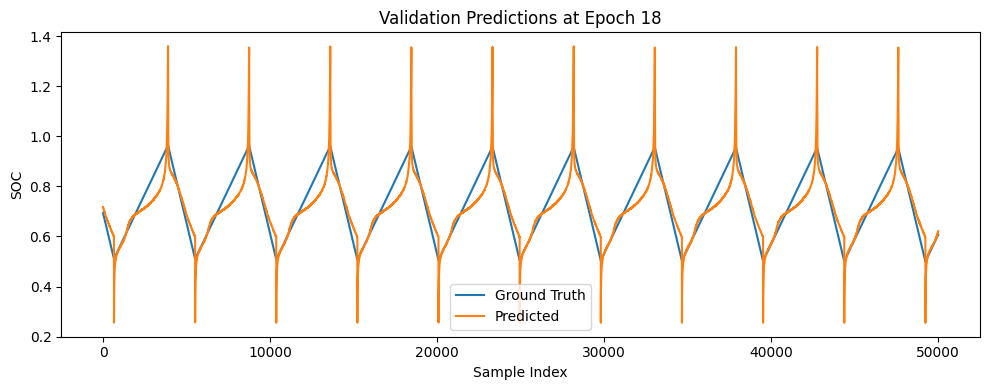

Epoch 019/30, Train MSE: 0.019406, Val MSE: 0.008776, NoImprove: 0


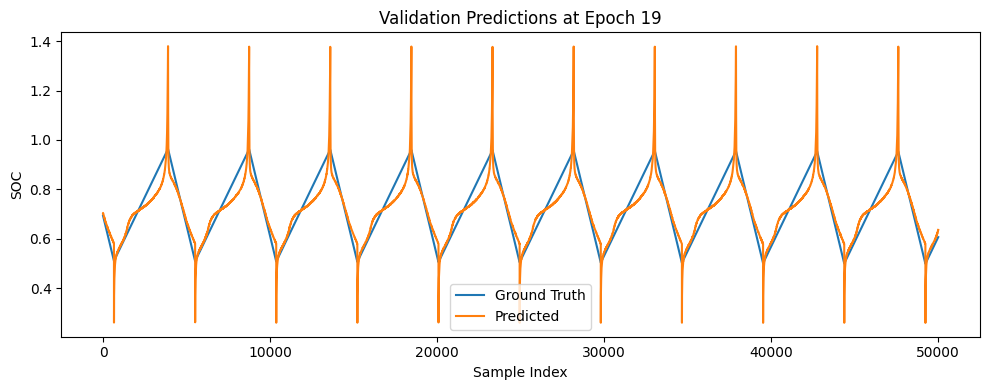

Epoch 020/30, Train MSE: 0.018391, Val MSE: 0.008745, NoImprove: 0


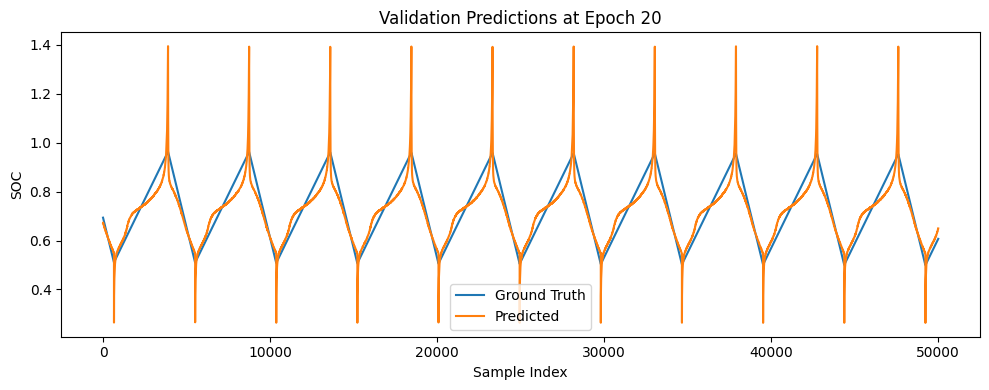

Epoch 021/30, Train MSE: 0.017892, Val MSE: 0.008670, NoImprove: 0


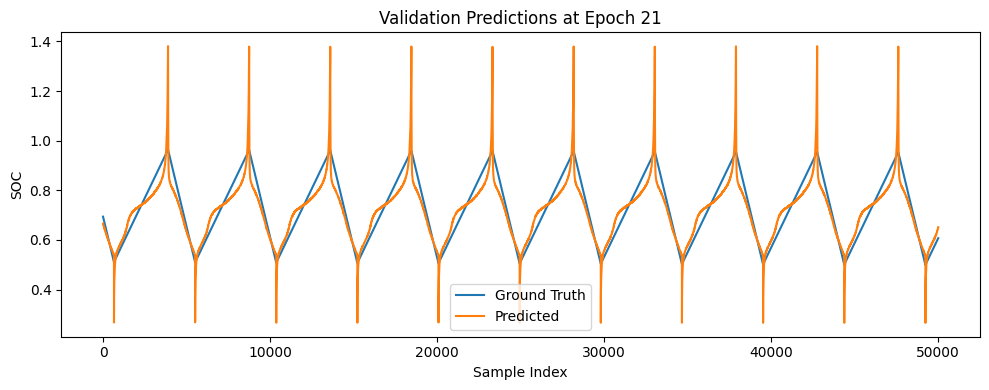

Epoch 022/30, Train MSE: 0.017130, Val MSE: 0.008120, NoImprove: 0


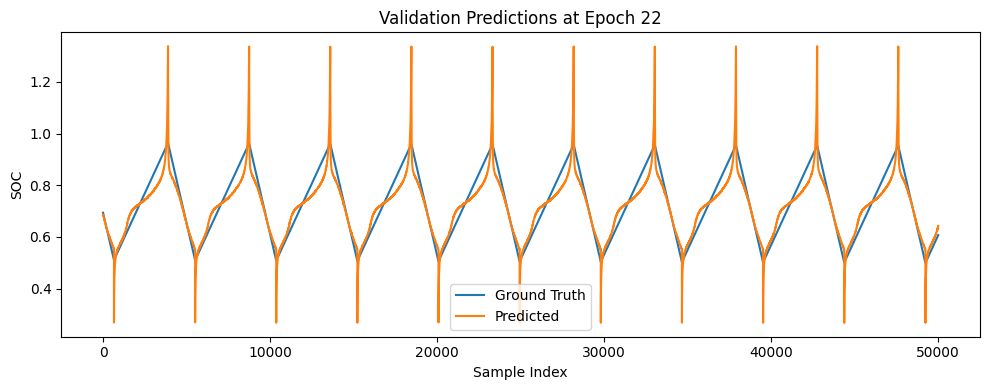

Epoch 023/30, Train MSE: 0.016365, Val MSE: 0.007892, NoImprove: 0


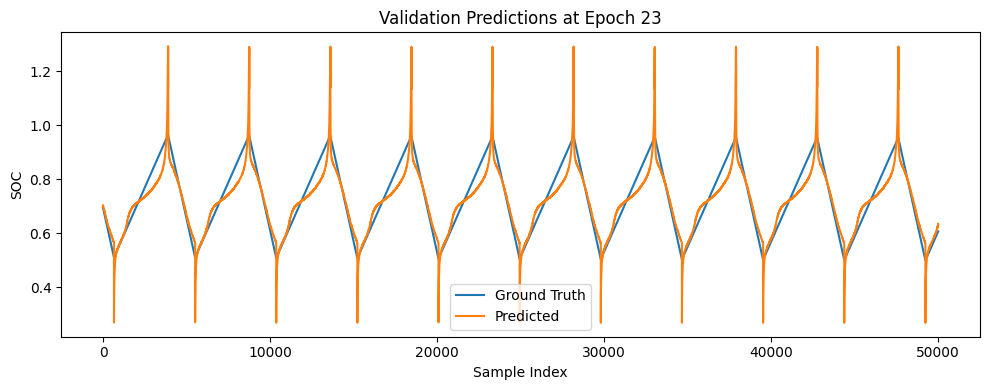

Epoch 024/30, Train MSE: 0.015817, Val MSE: 0.007735, NoImprove: 0


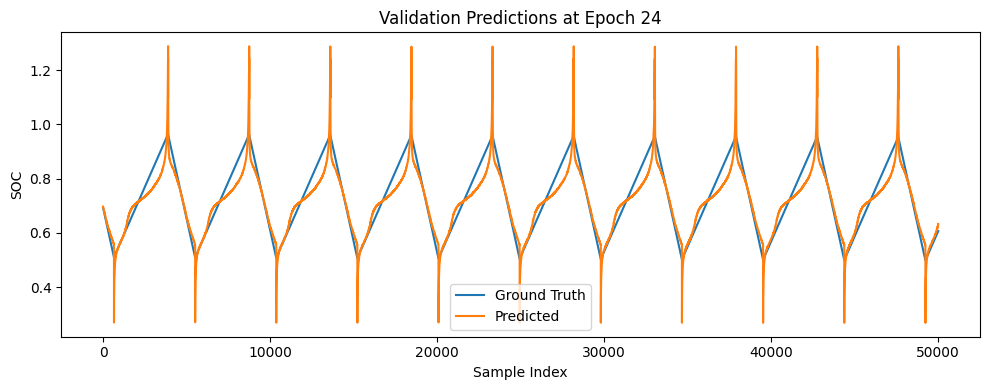

Epoch 025/30, Train MSE: 0.015205, Val MSE: 0.007563, NoImprove: 0


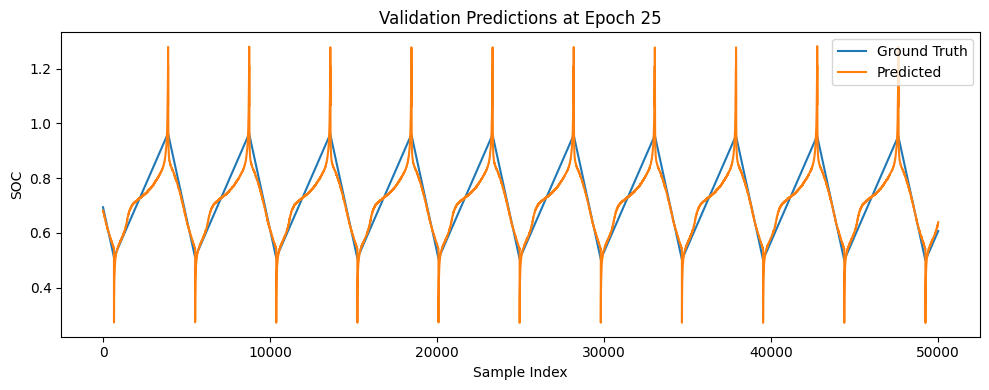

Epoch 026/30, Train MSE: 0.014750, Val MSE: 0.007290, NoImprove: 0


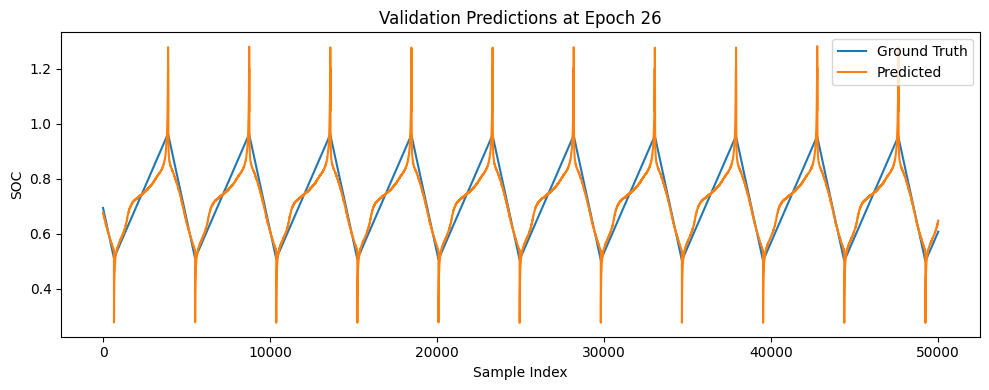

Epoch 027/30, Train MSE: 0.014310, Val MSE: 0.006920, NoImprove: 0


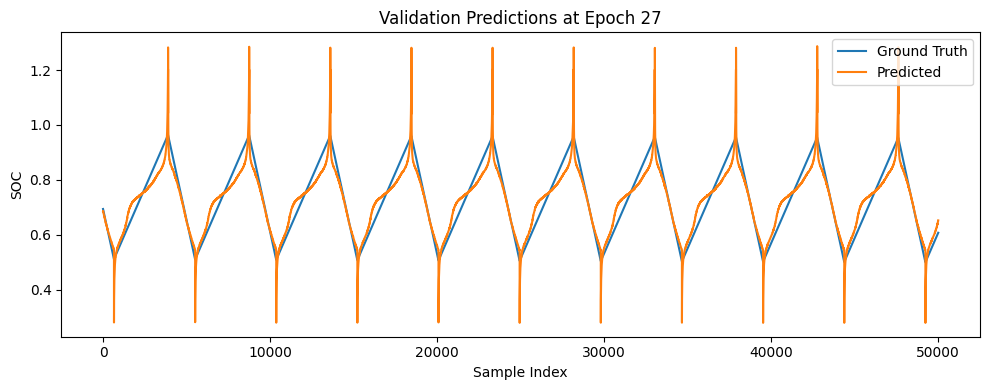

Epoch 028/30, Train MSE: 0.013931, Val MSE: 0.006705, NoImprove: 0


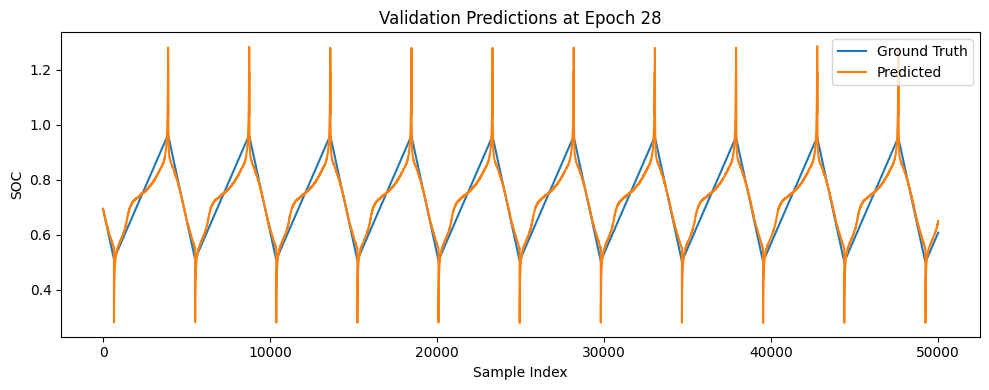

Epoch 029/30, Train MSE: 0.013504, Val MSE: 0.006699, NoImprove: 0


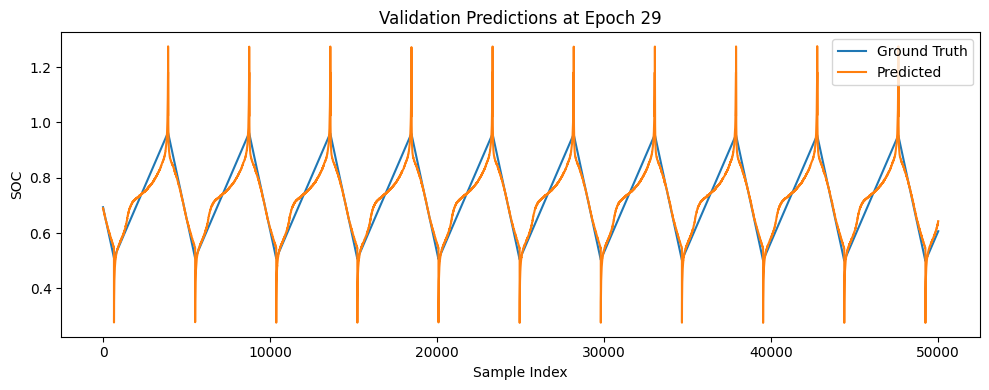

Epoch 030/30, Train MSE: 0.013165, Val MSE: 0.006782, NoImprove: 1


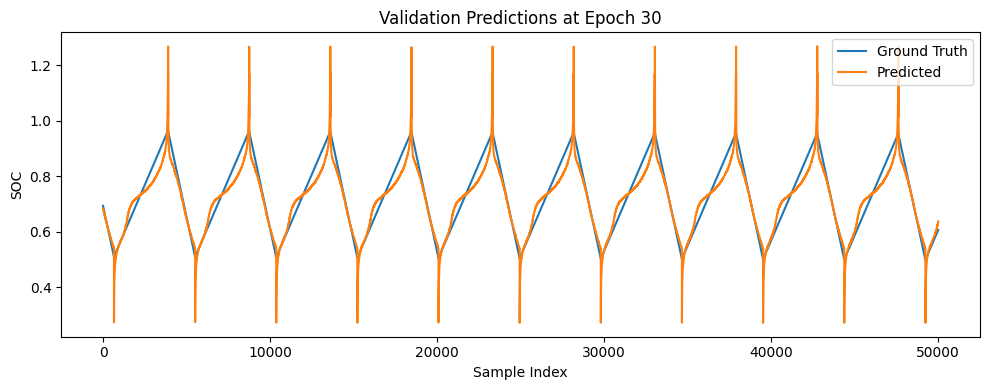


Best model reloaded with val_loss = 0.006699


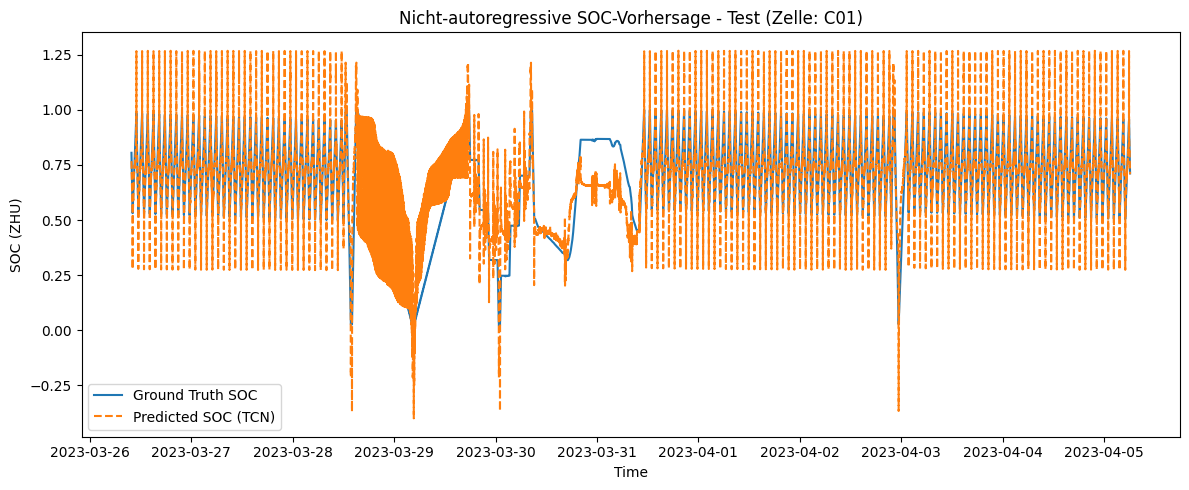

Test-Plot gespeichert unter: models/prediction_test.png
Bestes Modell gespeichert unter: models/best_tcn_soc_model.pth


In [2]:
import os
import sys
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

torch.cuda.empty_cache()

###############################################################################
# 1) Laden der Daten, Reduktion auf 25%, zeitbasiertes Split in [Train, Val, Test]
###############################################################################
def load_cell_data(data_dir: Path):
    """Lade df.parquet aus dem Unterordner 'MGFarm_18650_C01'."""
    dataframes = {}
    folder = data_dir / "MGFarm_18650_C01"
    if folder.exists() and folder.is_dir():
        df_path = folder / 'df.parquet'
        if df_path.exists():
            df = pd.read_parquet(df_path)
            dataframes["C01"] = df
            print(f"Loaded {folder.name}")
        else:
            print(f"Warning: No df.parquet found in {folder.name}")
    else:
        print("Warning: Folder MGFarm_18650_C01 not found")
    return dataframes

# Anpassen an deinen Speicherort
data_dir = Path('/home/florianr/MG_Farm/5_Data/MGFarm_18650_Dataframes')
cell_data = load_cell_data(data_dir)

# Wir gehen davon aus, dass wir mindestens eine Zelle haben
cell_keys = sorted(cell_data.keys())[:1]
if len(cell_keys) < 1:
    raise ValueError("Keine Zelle gefunden; bitte prüfen.")

cell_name = cell_keys[0]  # z.B. 'C01'
df_full = cell_data[cell_name]

# 25% der Daten
sample_size = int(len(df_full) * 0.25)
df_small = df_full.head(sample_size).copy()

print(f"Gesamtdaten: {len(df_full)}, wir nehmen 25% = {sample_size} Zeilen.")

df_small['timestamp'] = pd.to_datetime(df_small['Absolute_Time[yyyy-mm-dd hh:mm:ss]'])

# Zeitbasierter Split (Train=40%, Val=40%, Test=20%)
len_small = len(df_small)
train_end = int(len_small * 0.4)
val_end   = int(len_small * 0.8)

df_train = df_small.iloc[:train_end]
df_val   = df_small.iloc[train_end:val_end]
df_test  = df_small.iloc[val_end:]

print(f"Train: {len(df_train)}  |  Val: {len(df_val)}  |  Test: {len(df_test)}")

###############################################################################
# 2) Skalierung von Voltage & Current
###############################################################################
scaler = StandardScaler()
features_to_scale = ['Voltage[V]', 'Current[A]']

scaler.fit(df_train[features_to_scale])

df_train_scaled = df_train.copy()
df_val_scaled   = df_val.copy()
df_test_scaled  = df_test.copy()

df_train_scaled[features_to_scale] = scaler.transform(df_train_scaled[features_to_scale])
df_val_scaled[features_to_scale]   = scaler.transform(df_val_scaled[features_to_scale])
df_test_scaled[features_to_scale]  = scaler.transform(df_test_scaled[features_to_scale])

###############################################################################
# 3) Dataset-Klasse (seq2one, NICHT autoregressiv, KEIN SOC als Input)
###############################################################################
class SequenceDataset(Dataset):
    """
    - X[t] = [Voltage, Current] für t..t+seq_len-1
    - y[t] = SOC an (t + seq_len)
    """
    def __init__(self, df, seq_len=60):
        self.seq_len = seq_len
        self.features = df[["Voltage[V]", "Current[A]"]].values  # shape=(N, 2)
        self.labels   = df["SOC_ZHU"].values                     # shape=(N,)

    def __len__(self):
        return len(self.labels) - self.seq_len

    def __getitem__(self, idx):
        x_seq = self.features[idx : idx + self.seq_len]   # shape (seq_len, 2)
        y_val = self.labels[idx + self.seq_len]
        return torch.tensor(x_seq, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32)

seq_length = 60
train_dataset = SequenceDataset(df_train_scaled, seq_len=seq_length)
val_dataset   = SequenceDataset(df_val_scaled,   seq_len=seq_length)
test_dataset  = SequenceDataset(df_test_scaled,  seq_len=seq_length)

train_loader = DataLoader(train_dataset, batch_size=50000, shuffle=True,  drop_last=True)
val_loader   = DataLoader(val_dataset,   batch_size=50000, shuffle=False, drop_last=True)
test_loader  = DataLoader(test_dataset,  batch_size=50000, shuffle=False, drop_last=True)

###############################################################################
# 4) TCN-Modell
###############################################################################
class Chomp1d(nn.Module):
    """
    Hilfsklasse, um beim 1D-Conv das 'causal padding' abzuschneiden
    (damit nichts aus der "Zukunft" geleakt wird).
    """
    def __init__(self, chomp_size: int):
        super().__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        # x shape: (batch_size, out_channels, seq_len + padding)
        return x[:, :, :-self.chomp_size]

class TCNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, dilation, padding, dropout=0.2):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size,
                               stride=stride, dilation=dilation, padding=padding)
        self.chomp1 = Chomp1d(chomp_size=padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=kernel_size,
                               stride=stride, dilation=dilation, padding=padding)
        self.chomp2 = Chomp1d(chomp_size=padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(
            self.conv1, self.chomp1, self.relu1, self.dropout1,
            self.conv2, self.chomp2, self.relu2, self.dropout2
        )

        # "Residual Connection" evtl. Downsampling, falls in_channels != out_channels
        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if (in_channels != out_channels) else None
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

class TCN(nn.Module):
    """
    Einfaches TCN mit einer Liste von TCNBlocks.
    - input_size: Anzahl Features (hier 2: Voltage, Current).
    - num_channels: Liste der Channelanzahlen je Block, z.B. [32, 32].
    - kernel_size, dropout: Hyperparameter.
    """
    def __init__(self, input_size=2, num_channels=[32, 32], kernel_size=2, dropout=0.2):
        super().__init__()
        layers = []
        num_levels = len(num_channels)

        for i in range(num_levels):
            in_ch = input_size if i == 0 else num_channels[i-1]
            out_ch = num_channels[i]
            dilation_size = 2 ** i
            # Für kernel_size=2 => padding = (kernel_size - 1) * dilation
            # => padding = 1 * dilation_size
            padding = (kernel_size - 1) * dilation_size

            block = TCNBlock(
                in_channels=in_ch,
                out_channels=out_ch,
                kernel_size=kernel_size,
                stride=1,
                dilation=dilation_size,
                padding=padding,
                dropout=dropout
            )
            layers.append(block)

        self.tcn = nn.Sequential(*layers)
        self.fc  = nn.Linear(num_channels[-1], 1)  # Finale FC-Schicht

    def forward(self, x):
        """
        x kommt als (batch_size, seq_len, input_size)
        => wir permutieren in (batch_size, input_size, seq_len),
           weil Conv1d => (N, C_in, L).
        """
        x = x.permute(0, 2, 1)  # => shape: (batch_size, 2, seq_len)
        y = self.tcn(x)         # => shape: (batch_size, out_ch, seq_len)
        # Nimm den letzten Zeitschritt, um "1-step Vorhersage" zu erhalten
        # => y[:, :, -1] => shape: (batch_size, out_ch)
        last_out = y[:, :, -1]
        out = self.fc(last_out)
        return out.squeeze(-1)

# Instanziere TCN
model = TCN(input_size=2, num_channels=[32, 32], kernel_size=2, dropout=0.2)

###############################################################################
# 5) Training mit Validation + Early Stopping
###############################################################################
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Plot: Datenaufteilung
plt.figure(figsize=(12,6))
plt.plot(df_small['timestamp'], df_small['SOC_ZHU'], 'k-', label='SOC (alle Daten)')
plt.axvspan(df_train['timestamp'].iloc[0],
            df_train['timestamp'].iloc[-1],
            color='green', alpha=0.3, label='Training')
plt.axvspan(df_val['timestamp'].iloc[0],
            df_val['timestamp'].iloc[-1],
            color='orange', alpha=0.3, label='Validation')
plt.axvspan(df_test['timestamp'].iloc[0],
            df_test['timestamp'].iloc[-1],
            color='red', alpha=0.3, label='Test')
plt.xlabel('Time')
plt.ylabel('SOC (ZHU)')
plt.title('Datenaufteilung')
plt.legend()
plt.tight_layout()
plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

epochs = 30
patience = 5
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_state = None

accumulation_steps = 10

for epoch in range(1, epochs+1):
    model.train()
    train_losses = []
    optimizer.zero_grad()

    for i, (x_batch, y_batch) in enumerate(train_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch) / accumulation_steps
        loss.backward()

        if (i + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

        train_losses.append(loss.item() * accumulation_steps)

    mean_train_loss = np.mean(train_losses)

    # Validierung
    model.eval()
    val_losses = []
    all_y_val = []
    all_y_pred = []
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            y_pred_val = model(x_val)
            v_loss = criterion(y_pred_val, y_val)
            val_losses.append(v_loss.item())
            if not all_y_val:  # nur ersten Batch plotten
                all_y_val.append(y_val.cpu().numpy())
                all_y_pred.append(y_pred_val.cpu().numpy())
    mean_val_loss = np.mean(val_losses)

    # Early Stopping
    if mean_val_loss < best_val_loss:
        best_val_loss = mean_val_loss
        best_model_state = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch} because val_loss not improved.")
            break

    print(f"Epoch {epoch:03d}/{epochs}, Train MSE: {mean_train_loss:.6f}, Val MSE: {mean_val_loss:.6f}, NoImprove: {epochs_no_improve}")

    # Plot Validation (erster Batch)
    y_val_example = all_y_val[0].flatten()
    y_pred_example = all_y_pred[0].flatten()
    plt.figure(figsize=(10,4))
    plt.plot(y_val_example, label='Ground Truth')
    plt.plot(y_pred_example, label='Predicted')
    plt.title(f"Validation Predictions at Epoch {epoch}")
    plt.xlabel("Sample Index")
    plt.ylabel("SOC")
    plt.legend()
    plt.tight_layout()
    plt.show(block=False)
    plt.pause(1)
    plt.close()

# Bestes Modell laden
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"\nBest model reloaded with val_loss = {best_val_loss:.6f}")

###############################################################################
# 6) Test-Vorhersage (NICHT autoregressiv)
###############################################################################
model.eval()
test_predictions = []
test_targets = []

with torch.no_grad():
    for x_test, y_test in test_loader:
        x_test, y_test = x_test.to(device), y_test.to(device)
        y_pred_test = model(x_test)
        test_predictions.append(y_pred_test.cpu().numpy())
        test_targets.append(y_test.cpu().numpy())

test_predictions = np.concatenate(test_predictions)
test_targets = np.concatenate(test_targets)

time_test = df_test['timestamp'].values[seq_length:seq_length + len(test_targets)]

plt.figure(figsize=(12,5))
plt.plot(time_test, test_targets, label="Ground Truth SOC", linestyle='-')
plt.plot(time_test, test_predictions, label="Predicted SOC (TCN)", linestyle='--')
plt.title(f"Nicht-autoregressive SOC-Vorhersage - Test (Zelle: {cell_name})")
plt.xlabel("Time")
plt.ylabel("SOC (ZHU)")
plt.legend()
plt.tight_layout()

models_dir = Path(__file__).parent / "models" if "__file__" in globals() else Path("models")
os.makedirs(models_dir, exist_ok=True)
plot_file = models_dir / "prediction_test.png"
plt.savefig(plot_file)
plt.show()
print(f"Test-Plot gespeichert unter: {plot_file}")

model_path = models_dir / "best_tcn_soc_model.pth"
torch.save(model.state_dict(), model_path)
print(f"Bestes Modell gespeichert unter: {model_path}")


# TCM Hyperparametertuning Test

In [3]:
import os
import sys
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import optuna
from tqdm import tqdm  # Für Fortschrittsbalken
import shutil

torch.cuda.empty_cache()

# Ordner für Hyperparametertuning-Ergebnisse (HPT)
hpt_folder = Path(__file__).parent / "HPT" if '__file__' in globals() else Path("HPT")
os.makedirs(hpt_folder, exist_ok=True)

###############################################################################
# 1) Laden der Daten, Reduktion auf 25%, zeitbasierter Split in [Train, Val, Test]
###############################################################################
def load_cell_data(data_dir: Path):
    """Lade df.parquet aus dem Unterordner 'MGFarm_18650_C01'."""
    dataframes = {}
    folder = data_dir / "MGFarm_18650_C01"
    if folder.exists() and folder.is_dir():
        df_path = folder / 'df.parquet'
        if df_path.exists():
            df = pd.read_parquet(df_path)
            dataframes["C01"] = df
            print(f"[INFO] Loaded {folder.name}")
        else:
            print(f"[WARN] No df.parquet found in {folder.name}")
    else:
        print("[WARN] Folder MGFarm_18650_C01 not found")
    return dataframes

# Passe den Speicherort an
data_dir = Path('/home/florianr/MG_Farm/5_Data/MGFarm_18650_Dataframes')
cell_data = load_cell_data(data_dir)

cell_keys = sorted(cell_data.keys())[:1]
if len(cell_keys) < 1:
    raise ValueError("Keine Zelle gefunden; bitte prüfen.")

cell_name = cell_keys[0]  # z.B. 'C01'
df_full = cell_data[cell_name]

# Verwende 25% der Daten
sample_size = int(len(df_full) * 0.25)
df_small = df_full.head(sample_size).copy()
print(f"[INFO] Gesamtdaten: {len(df_full)}, verwende 25% = {sample_size} Zeilen.")

# Konvertiere Timestamp (Daten liegen in Sekunden)
df_small['timestamp'] = pd.to_datetime(df_small['Absolute_Time[yyyy-mm-dd hh:mm:ss]'])

# Zeitbasiertes Split (Train: 40%, Val: 40%, Test: 20%)
len_small = len(df_small)
train_end = int(len_small * 0.4)
val_end   = int(len_small * 0.8)

df_train = df_small.iloc[:train_end]
df_val   = df_small.iloc[train_end:val_end]
df_test  = df_small.iloc[val_end:]
print(f"[INFO] Split: Train: {len(df_train)} | Val: {len(df_val)} | Test: {len(df_test)}")

###############################################################################
# 2) Skalierung von Voltage & Current
###############################################################################
scaler = StandardScaler()
features_to_scale = ['Voltage[V]', 'Current[A]']

# Fit nur auf Trainingsdaten
scaler.fit(df_train[features_to_scale])

df_train_scaled = df_train.copy()
df_val_scaled   = df_val.copy()
df_test_scaled  = df_test.copy()

df_train_scaled[features_to_scale] = scaler.transform(df_train_scaled[features_to_scale])
df_val_scaled[features_to_scale]   = scaler.transform(df_val_scaled[features_to_scale])
df_test_scaled[features_to_scale]  = scaler.transform(df_test_scaled[features_to_scale])

###############################################################################
# 3) Dataset-Klasse (seq2one, NICHT autoregressiv, SOC nur als Label)
###############################################################################
class SequenceDataset(Dataset):
    """
    Für jedes Sample:
      - Input: Fenster aus [Voltage, Current] über seq_len Sekunden
      - Label: SOC an (t + seq_len) (immer 1 Schritt voraus)
    """
    def __init__(self, df, seq_len=60):
        self.seq_len = seq_len
        self.features = df[["Voltage[V]", "Current[A]"]].values  # shape=(N, 2)
        self.labels   = df["SOC_ZHU"].values                     # shape=(N,)

    def __len__(self):
        return len(self.labels) - self.seq_len

    def __getitem__(self, idx):
        x_seq = self.features[idx : idx + self.seq_len]   # shape: (seq_len, 2)
        y_val = self.labels[idx + self.seq_len]             # Vorhersage: 1 Schritt
        return torch.tensor(x_seq, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32)

###############################################################################
# 4) TCN-Modell und Hilfsklassen
###############################################################################
class Chomp1d(nn.Module):
    """
    Schneidet das "causal padding" beim 1D-Convolution ab.
    """
    def __init__(self, chomp_size: int):
        super().__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        # x shape: (batch_size, out_channels, seq_len + padding)
        return x[:, :, :-self.chomp_size]

class TCNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, dilation, padding, dropout=0.2):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size,
                               stride=stride, dilation=dilation, padding=padding)
        self.chomp1 = Chomp1d(chomp_size=padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=kernel_size,
                               stride=stride, dilation=dilation, padding=padding)
        self.chomp2 = Chomp1d(chomp_size=padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(
            self.conv1, self.chomp1, self.relu1, self.dropout1,
            self.conv2, self.chomp2, self.relu2, self.dropout2
        )

        # Residual Connection; falls in_channels != out_channels, Downsampling
        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if (in_channels != out_channels) else None
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

class TCN(nn.Module):
    """
    Einfaches TCN bestehend aus einer Liste von TCN-Blöcken.
    - input_size: Anzahl der Features (hier 2: Voltage, Current)
    - num_channels: Liste der Kanalzahlen pro Block (z. B. [32, 32])
    - kernel_size und dropout sind hyperparametrierbar.
    """
    def __init__(self, input_size=2, num_channels=[32, 32], kernel_size=2, dropout=0.2):
        super().__init__()
        layers = []
        num_levels = len(num_channels)

        for i in range(num_levels):
            in_ch = input_size if i == 0 else num_channels[i-1]
            out_ch = num_channels[i]
            dilation_size = 2 ** i
            # Padding = (kernel_size - 1) * dilation_size
            padding = (kernel_size - 1) * dilation_size

            block = TCNBlock(
                in_channels=in_ch,
                out_channels=out_ch,
                kernel_size=kernel_size,
                stride=1,
                dilation=dilation_size,
                padding=padding,
                dropout=dropout
            )
            layers.append(block)

        self.tcn = nn.Sequential(*layers)
        self.fc  = nn.Linear(num_channels[-1], 1)  # finale Fully Connected-Schicht

    def forward(self, x):
        """
        x kommt als (batch_size, seq_len, input_size) rein.
        Wir permutieren zu (batch_size, input_size, seq_len), da Conv1d dies erwartet.
        """
        x = x.permute(0, 2, 1)  # => shape: (batch_size, 2, seq_len)
        y = self.tcn(x)         # => shape: (batch_size, out_channels, seq_len)
        # Nimm den letzten Zeitschritt für die 1-Schritt Vorhersage
        last_out = y[:, :, -1]
        out = self.fc(last_out)
        return out.squeeze(-1)

###############################################################################
# 5) Optuna Objective-Funktion für das Hyperparametertuning mit tqdm
###############################################################################
def objective(trial: optuna.Trial):
    # Hyperparameter
    seq_length = trial.suggest_int("seq_length", 60, 900, step=30)  # in Sekunden
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    kernel_size = trial.suggest_int("kernel_size", 2, 5)
    dropout = trial.suggest_float("dropout", 0.0, 0.5)
    n_ch1 = trial.suggest_int("n_ch1", 16, 128, step=16)
    n_ch2 = trial.suggest_int("n_ch2", 16, 128, step=16)
    num_channels = [n_ch1, n_ch2]
    batch_size = trial.suggest_int("batch_size", 32, 512, step=32)

    print(f"\n[TRIAL {trial.number}] Beginne mit: seq_length={seq_length}, lr={lr:.5f}, "
          f"kernel_size={kernel_size}, dropout={dropout:.2f}, num_channels={num_channels}, "
          f"batch_size={batch_size}")

    # Erstelle Datasets
    train_dataset = SequenceDataset(df_train_scaled, seq_len=seq_length)
    val_dataset   = SequenceDataset(df_val_scaled, seq_len=seq_length)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    # Modell instanziieren
    model = TCN(input_size=2, num_channels=num_channels, kernel_size=kernel_size, dropout=dropout)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    n_epochs = 10
    best_trial_val = float('inf')
    best_model_state = None

    epoch_pbar = tqdm(range(n_epochs), desc=f"Trial {trial.number} Epochs", leave=False)
    for epoch in epoch_pbar:
        model.train()
        train_loss = 0.0
        # Trainingsschleife mit Fortschrittsbalken
        for x_batch, y_batch in tqdm(train_loader, desc="Train Batches", leave=False):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            y_pred = model(x_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * x_batch.size(0)
        train_loss /= len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for x_val, y_val in tqdm(val_loader, desc="Val Batches", leave=False):
                x_val, y_val = x_val.to(device), y_val.to(device)
                y_pred_val = model(x_val)
                loss_val = criterion(y_pred_val, y_val)
                val_loss += loss_val.item() * x_val.size(0)
        val_loss /= len(val_loader.dataset)

        epoch_pbar.set_postfix({"train_loss": f"{train_loss:.6f}", "val_loss": f"{val_loss:.6f}"})

        # Speichere bestes Modell im Trial
        if val_loss < best_trial_val:
            best_trial_val = val_loss
            best_model_state = model.state_dict()

        trial.report(val_loss, epoch)
        if trial.should_prune():
            print(f"[TRIAL {trial.number}] Pruned at epoch {epoch}")
            raise optuna.exceptions.TrialPruned()

    if best_model_state is not None:
        model_file = hpt_folder / f"model_trial_{trial.number}.pth"
        torch.save(best_model_state, model_file)
        trial.set_user_attr("model_path", str(model_file))
        print(f"[TRIAL {trial.number}] Bestes Modell gespeichert unter: {model_file}")

    torch.cuda.empty_cache()
    print(f"[TRIAL {trial.number}] Abgeschlossen mit val_loss: {best_trial_val:.6f}")
    return best_trial_val

###############################################################################
# 6) Optuna-Studie starten und Ergebnisse speichern
###############################################################################
if __name__ == '__main__':
    print("[INFO] Starte Hyperparametertuning mit Optuna ...")
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=50)

    print("\n[INFO] Beste Trial:")
    best_trial = study.best_trial
    print(f"  Trial {best_trial.number} | Value: {best_trial.value:.6f}")
    for key, value in best_trial.params.items():
        print(f"    {key}: {value}")

    # Speichere den Modell-State des besten Trials als best_tcn_soc_model.pth
    best_model_path = best_trial.user_attrs.get("model_path", None)
    if best_model_path is not None:
        final_model_path = hpt_folder / "best_tcn_soc_model.pth"
        shutil.copy(best_model_path, final_model_path)
        print(f"[INFO] Bestes Modell wurde gespeichert unter: {final_model_path}")
    else:
        print("[WARN] Kein Modellpfad im besten Trial gefunden!")

    # Speichere alle Trial-Informationen in einer Excel-Datei
    records = []
    for trial in study.trials:
        record = {
            "trial_number": trial.number,
            "value": trial.value,
            "state": trial.state.name,
        }
        record.update(trial.params)
        record["model_path"] = trial.user_attrs.get("model_path", "")
        records.append(record)

    df_trials = pd.DataFrame(records)
    excel_file = hpt_folder / "hpt_trials.xlsx"
    df_trials.to_excel(excel_file, index=False)
    print(f"[INFO] Alle Trial-Informationen wurden in '{excel_file}' gespeichert.")


[INFO] Loaded MGFarm_18650_C01
[INFO] Gesamtdaten: 17167046, verwende 25% = 4291761 Zeilen.
[INFO] Split: Train: 1716704 | Val: 1716704 | Test: 858353


[I 2025-03-27 14:16:50,833] A new study created in memory with name: no-name-4d186c99-9e52-4c83-9384-dff87c2f948f


[INFO] Starte Hyperparametertuning mit Optuna ...

[TRIAL 0] Beginne mit: seq_length=720, lr=0.00058, kernel_size=3, dropout=0.03, num_channels=[16, 80], batch_size=512


[W 2025-03-27 14:18:22,594] Trial 0 failed with parameters: {'seq_length': 720, 'lr': 0.0005849835754690967, 'kernel_size': 3, 'dropout': 0.033458503076216894, 'n_ch1': 16, 'n_ch2': 80, 'batch_size': 512} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/florianr/anaconda3/envs/ml1/lib/python3.9/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_182745/2140980758.py", line 246, in objective
    train_loss += loss.item() * x_batch.size(0)
KeyboardInterrupt
[W 2025-03-27 14:18:22,595] Trial 0 failed with value None.


KeyboardInterrupt: 